# Evaluate

* Before you get started, please make sure your `vocab.json` and `config.max_answers` corresponds to your model's parameters to be evaluated.

In [3]:
eval_config = {
    "model_path": "logs/2021-07-12_18:15:03.pth",
    "dataset": 'test' # or 'val'
}
dump_path = "data/results/{}_val2014_real_results.json".format(eval_config["dataset"])

## Define our evaluation function:

In [4]:
import sys
import os.path
import math
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from tqdm import tqdm

import config
import data
import model
import utils
import train

def evaluate(net, loader, tracker, prefix='', epoch=0):
    """ Run an epoch over the given loader """
    net.eval()
    tracker_class, tracker_params = tracker.MeanMonitor, {}
    answ = []
    idxs = []
    accs = []

    tq = tqdm(loader, desc='{} E{:03d}'.format(prefix, epoch), ncols=0)
    loss_tracker = tracker.track('{}_loss'.format(prefix), tracker_class(**tracker_params))
    acc_tracker = tracker.track('{}_acc'.format(prefix), tracker_class(**tracker_params))

    log_softmax = nn.LogSoftmax(dim=0).cuda()
    for v, q, a, idx, q_len in tq:
        var_params = {
            'requires_grad': False,
        }
        v = Variable(v.cuda(non_blocking=True), **var_params)
        q = Variable(q.cuda(non_blocking=True), **var_params)
        a = Variable(a.cuda(non_blocking=True), **var_params)
        q_len = Variable(q_len.cuda(non_blocking=True), **var_params)

        out = net(v, q, q_len) # output of the net

        nll = -log_softmax(out)
        loss = (nll * a / 10).sum(dim=1).mean()
        acc = utils.batch_accuracy(out.data, a.data).cpu()

        # store information about evaluation of this minibatch
        _, answer = out.data.cpu().max(dim=1)
        answ.append(answer.view(-1))
        accs.append(acc.view(-1))
        idxs.append(idx.view(-1).clone())
        
        loss_tracker.append(loss.item())
        # acc_tracker.append(acc.mean())
        for a in acc:
            acc_tracker.append(a.item())
        fmt = '{:.4f}'.format
        tq.set_postfix(loss=fmt(loss_tracker.mean.value), acc=fmt(acc_tracker.mean.value))

    answ = list(torch.cat(answ, dim=0))
    accs = list(torch.cat(accs, dim=0))
    idxs = list(torch.cat(idxs, dim=0))
    return answ, accs, idxs


## Load your model:

In [5]:
if eval_config == 'val':
    loader = data.get_loader(val=True)
else: loader = data.get_loader(test=True)

# Load model
log = torch.load(eval_config["model_path"]) # load from disk
if log is not None: print("Successfully loaded pretrained model from {}.".format(eval_config["model_path"]))
tokens = len(log['vocab']['question']) + 1 # retrieve the number of output layer nodes
net = nn.DataParallel(model.Net(loader.dataset.num_tokens)).cuda() # define the `net`
net.load_state_dict(log['weights']) # load parameters into `net`

optimizer = optim.Adam([p for p in net.parameters() if p.requires_grad])
tracker = utils.Tracker()

Successfully loaded pretrained model from logs/2021-07-12_18:15:03.pth.


## Evaluate the model now:

In [6]:
answ, accs, idxs = evaluate(net, loader, tracker, prefix='test', epoch=0)

test E000: 100% 168/168 [00:29<00:00,  5.70it/s, acc=0.3865, loss=2.4752]


## Generate a result JSON file for later visualization.

In [7]:
import numpy as np
import json

print("Average accuracy:", np.mean(accs))

with open('data/questions/{}.json'.format(eval_config["dataset"]), 'r') as fd:
   questions_json = json.load(fd)

with open('vocab.json', 'r') as fd:
   vocab = json.load(fd)
   answ_dict = vocab['answer']

question_ids = [question['question_id'] for question in questions_json['questions']]
results = []

for i in range(len(idxs)):
   results.append({"answer": list(answ_dict.keys())[list(answ_dict.values()).index(answ[i].item())], "question_id": question_ids[idxs[i]]})

with open(dump_path, 'w') as fd:
   json.dump(results, fd)

Average accuracy: 0.38649404


## Visualize it!

loading VQA annotations and questions into memory...
0:00:00.167992
creating index...
index created!
Loading and preparing results...     
DONE (t=0.02s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 38.66

Per Question Type Accuracy is the following:
is there a : 62.43
what is the : 19.61
what : 21.92
what does the : 13.15
none of the above : 40.38
is this a : 60.86
what is : 16.62
is he : 63.02
are the : 63.17
how many people are : 26.80
how many people are in : 23.71
does the : 65.39
what color is the : 28.77
is this an : 66.73
what color : 19.81
where is the : 10.45
is the : 61.74
what are the : 19.87
who is : 11.22
what is the man : 36.12
is the man : 65.24
are there : 56.33
what kind of : 21.33
what animal is : 60.30
why : 4.04
what type of : 19.11
where are the : 15.48
is this : 60.01
is the person : 50.70
how many : 24.60
are these : 60.61
is that a : 58.49
how : 5.67
what color are

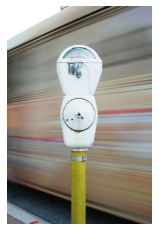

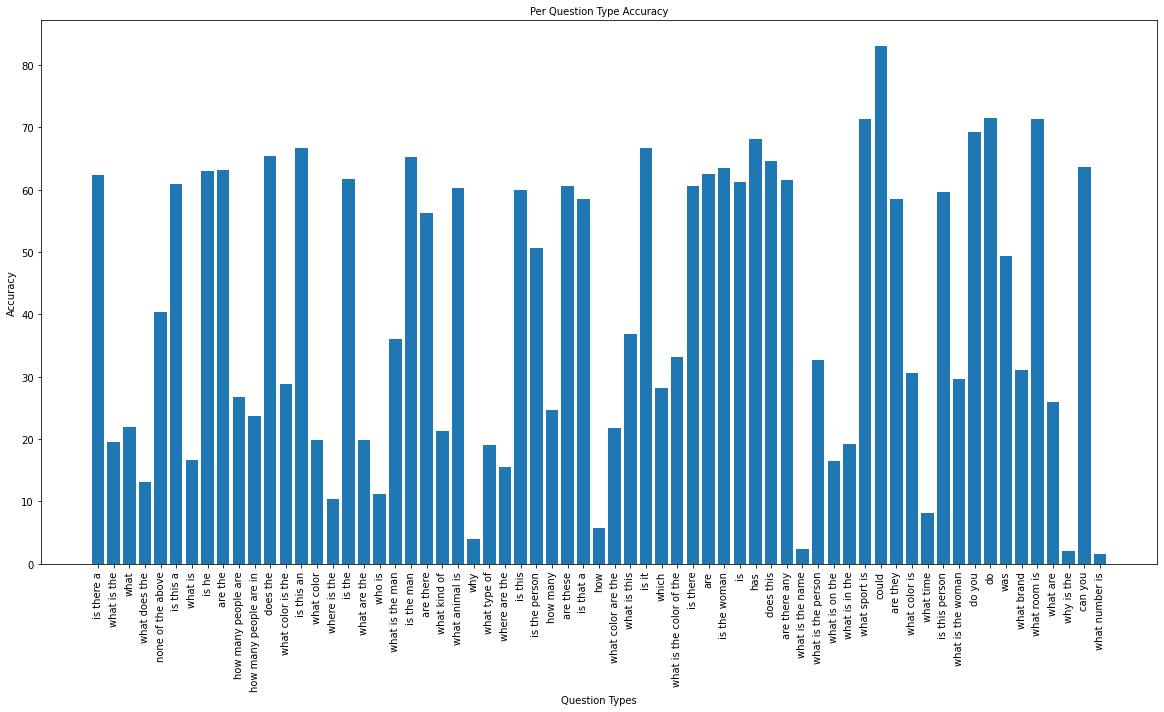

In [8]:
"""
input: results file (generated by your model), annotations file, questions file
output: evalAnsType, evalQuesType, evalQA, accuracy
"""
import sys
dataDir = '.'
sys.path.insert(0, '%s/PythonHelperTools/vqaTools' %(dataDir))
sys.path.insert(0, '%s/PythonEvaluationTools/vqaEvaluation' %(dataDir))
from vqa import VQA
from vqaEval import VQAEval
import matplotlib.pyplot as plt
import skimage.io as io
import json
import random
import os

# set up file names and paths
dataDir		='./data'
train_test_val = eval_config["dataset"]
dataSubType = 'train2014' if train_test_val == 'train' else 'val2014'
annFile     = '%s/annotations/%s.json'%(dataDir, train_test_val)
quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
# annFile     = '%s/results/val_fake_annotations.json'%(dataDir) # a tiny annotation file in 'results' for demo
# quesFile    = '%s/questions/%s.json'%(dataDir, train_test_val)
imgDir 		= '%s/images/%s/' %(dataDir, train_test_val)
resultType  = 'real'
fileTypes   = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType'] 

# An example result json file has been provided in './Results' folder.  

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] = ['%s/results/%s_%s_%s_%s.json'%(dataDir, train_test_val, dataSubType,  \
resultType, fileType) for fileType in fileTypes]

resFile = dump_path

# create vqa object and vqaRes object
vqa = VQA(annFile, quesFile)
vqaRes = vqa.loadRes(resFile, quesFile)

# create vqaEval object by taking vqa and vqaRes
vqaEval = VQAEval(vqa, vqaRes, n=2)   #n is precision of accuracy (number of places after decimal), default is 2

# evaluate results
"""
If you have a list of question ids on which you would like to evaluate your results, pass it as a list to below function
By default it uses all the question ids in annotation file
"""
vqaEval.evaluate() 

# print accuracies
print("\n")
print("Overall Accuracy is: %.02f\n" %(vqaEval.accuracy['overall']))
print("Per Question Type Accuracy is the following:")
for quesType in vqaEval.accuracy['perQuestionType']:
	print("%s : %.02f" %(quesType, vqaEval.accuracy['perQuestionType'][quesType]))
print("\n")
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval.accuracy['perAnswerType']:
	print("%s : %.02f" %(ansType, vqaEval.accuracy['perAnswerType'][ansType]))
print("\n")
# demo how to use evalQA to retrieve low score result
evals = [quesId for quesId in vqaEval.evalQA if vqaEval.evalQA[quesId]<35]   #35 is per question percentage accuracy
if len(evals) > 0:
	print('ground truth answers')
	randomEval = random.choice(evals)
	randomAnn = vqa.loadQA(randomEval)
	vqa.showQA(randomAnn)

	print('\n')
	print('generated answer (accuracy %.02f)'%(vqaEval.evalQA[randomEval]))
	ann = vqaRes.loadQA(randomEval)[0]
	print("Answer:   %s\n" %(ann['answer']))

	imgId = randomAnn[0]['image_id']
	imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
	if os.path.isfile(imgDir + imgFilename):
		I = io.imread(imgDir + imgFilename)
		plt.imshow(I)
		plt.axis('off')
		plt.show()

# plot accuracy for various question types
plt.figure(figsize=(20,10))
# plt.figure(dpi=80)
plt.bar(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].values(), align='center')
plt.xticks(range(len(vqaEval.accuracy['perQuestionType'])), vqaEval.accuracy['perQuestionType'].keys(), rotation='90', fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=10)
plt.xlabel('Question Types', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.show()

# save evaluation results to ./Results folder
json.dump(vqaEval.accuracy,     open(accuracyFile,     'w'))
json.dump(vqaEval.evalQA,       open(evalQAFile,       'w'))
json.dump(vqaEval.evalQuesType, open(evalQuesTypeFile, 'w'))
json.dump(vqaEval.evalAnsType,  open(evalAnsTypeFile,  'w'))
